In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
input_dir=r'C:\Users\beeja\Documents\Uni\2021\Semester2\COMP3710\Projects\ISIC2018_Task1-2_Training_Input_x2'
ground_truth_dir=r'C:\Users\beeja\Documents\Uni\2021\Semester2\COMP3710\Projects\ISIC2018_Task1_Training_GroundTruth_x2'

BATCH_SIZE=32
IMG_HEIGHT=256
IMG_WIDTH=256
TESTING_NUMBER=6

# Use split of 0.8, 0.1 and 0.1 for train, validation and test sets.
TRAIN_SIZE=0.8
VAL_SIZE=0.1
TEST_SIZE=0.1

In [3]:
def load_images():
    """
        Loads all images from a given directory into a tensor dataset.
    """
    
    # Load the input images into a TensorFlow dataset.
    image_in = os.listdir(input_dir)
    # First and last files aren't images, so image_in[1:-1] is used.
    image_in = [os.path.join(input_dir, path) for path in image_in[1:-1]]
    path_image_in = tf.data.Dataset.from_tensor_slices(image_in)
    in_dataset = path_image_in.map(decode_image_in, num_parallel_calls=AUTOTUNE)
    
    # Load the mask images into a TensorFlow dataset.
    image_ground_truth = os.listdir(ground_truth_dir)
    # First and last files aren't images, so image_ground_truth[1:-1] is used.
    image_ground_truth = [os.path.join(ground_truth_dir, path) for path in image_ground_truth[1:-1]]
    path_image_ground_truth = tf.data.Dataset.from_tensor_slices(image_ground_truth)
    mask_dataset = path_image_ground_truth.map(decode_image_ground_truth, num_parallel_calls=AUTOTUNE)
    
    
    image_dataset = tf.data.Dataset.zip((in_dataset, mask_dataset))
    
    implot_show(image_dataset.take(TESTING_NUMBER))
    return image_dataset

In [4]:
def decode_image_in(image):
    """
         Decode the input image into a TensorFlow tensor.
    """    
    raw_image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(raw_image, channels=3) # For colour images
    # Normalise to [0,1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT]) # Resize image to 256*256 
    
    return image

In [5]:
def decode_image_ground_truth(image):
    """
        Decode the ground truth image into a TensorFlow tensor.
    """
    
    GroundTruth_image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(GroundTruth_image, channels=1) # For b&w images
    # Normalise to [0,1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT]) # Resize image to 256*256
    
    return image

In [6]:
def implot_show(dataset):
    """
        Uses imshow to verify correctly loaded and processed data
    """
    
    for image_in, image_mask in dataset:
        
        print(image_in.shape)
        image_list = [image_in, image_mask]
        plt.figure(figsize=(18, 18))
        for i in range(2):
            print(image_list[i].shape)
            plt.subplot(1, 2, i + 1)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
            plt.axis('off')
        plt.show()

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


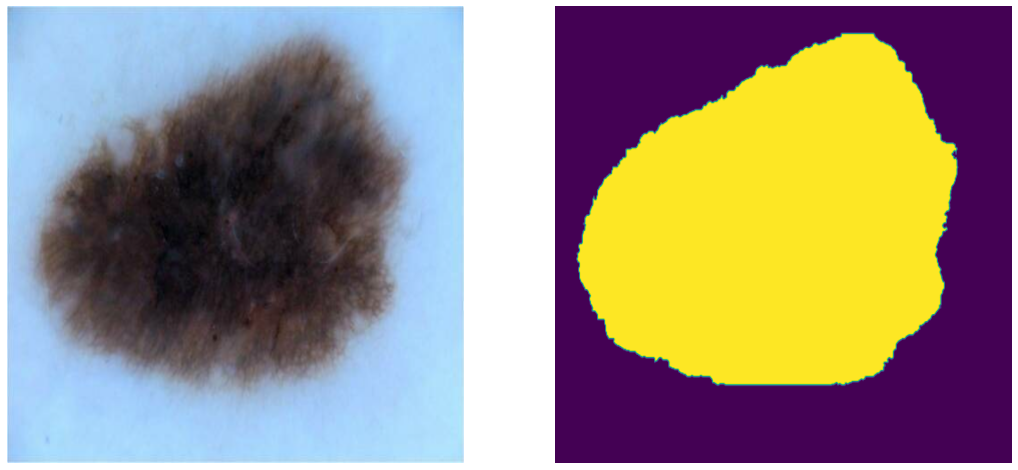

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


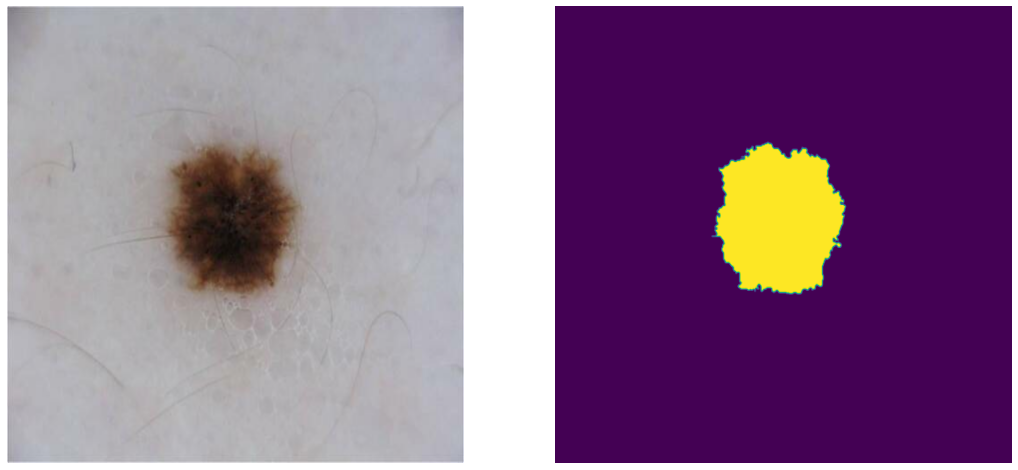

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


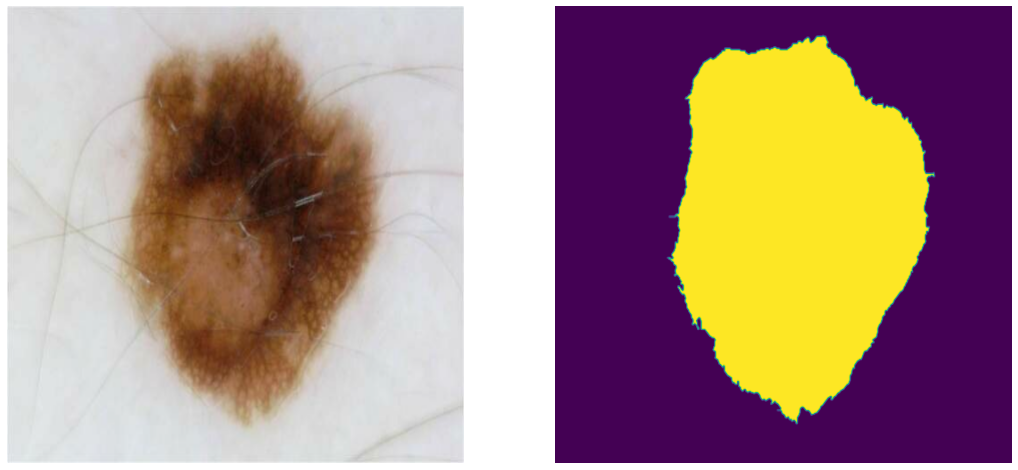

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


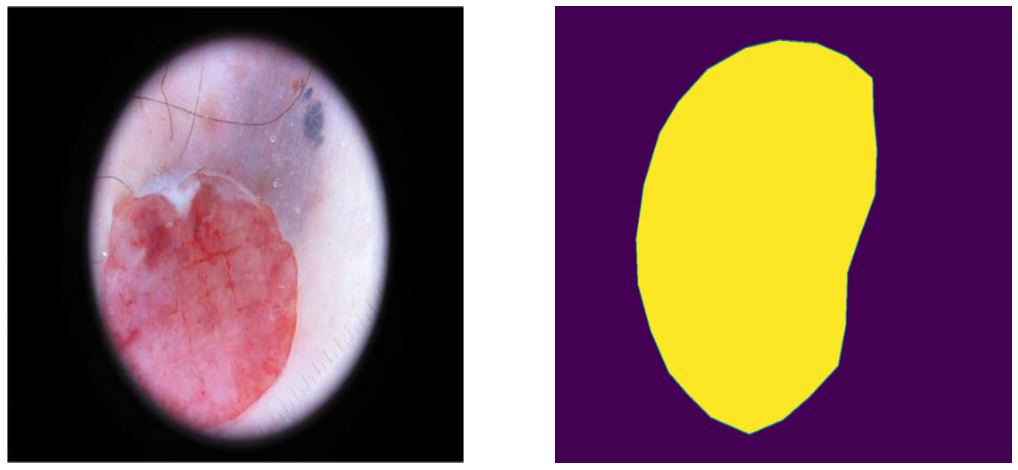

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


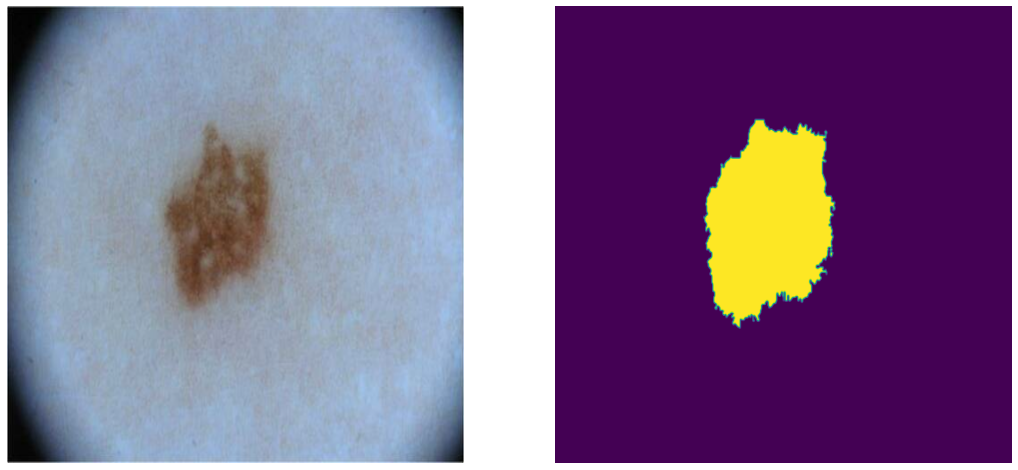

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


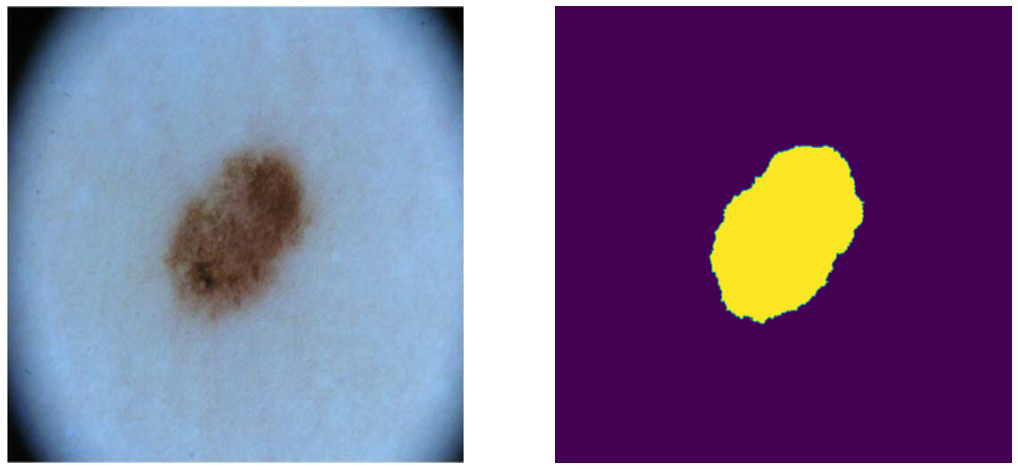

In [7]:
images = load_images()
dataset_size = len(list(images));

In [8]:
def split_dataset(image_dataset): 
    """
        Splits the given dataset into train, validation and test datasets.
    """
    train_size = int(TRAIN_SIZE * dataset_size)
    val_size = int(VAL_SIZE * dataset_size)
    test_size = int(TEST_SIZE * dataset_size)
   
    train_dataset = image_dataset.take(train_size)
    val_dataset = image_dataset.skip(train_size).take(val_size)
    test_dataset = image_dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_image, val_image, test_image = split_dataset(images)

In [10]:
STEPS_PER_EPOCH = (int(TRAIN_SIZE * dataset_size))//BATCH_SIZE

train_image = train_image.batch(BATCH_SIZE).repeat()
val_image = train_image.batch(BATCH_SIZE)
test_image = train_image.batch(1)

In [11]:
def dice_coefficient(y_true, y_predicted, epsilon=0.00001):
    """
        From [2], dice = (2 * |a . b|)/(|a|^2 + |b|^2)
        
        [2] - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    """
    axis = (0, 1, 2, 3)
    dice_numerator = 2. * K.sum(y_true * y_predicted, axis=axis) + epsilon
    dice_denominator = K.sum(y_true * y_true, axis=axis) + K.sum(y_pred * y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

In [12]:
def context(input, filters, name):
    """
        From [1], the context module is defined as:
            "Each context module is in fact a pre-activation residual block with two 
            3x3x3 convolutional layers and a dropout layer in between."
            
        Returns the resultant input after being activated by the context module.
    """
    
    
    kernel_size = (3, 3)
    alpha = 0.01
    
    layer1 = layers.Conv2D(filters, kernel_size, padding = 'same')(input)
    layer1 = layers.BatchNormalization()(layer1)
    layer1 = layers.LeakyReLU(alpha)(layer1)
    layer1 = layers.Dropout(0.3)(layer1)
    
    layer2 = layers.Conv2D(filters, kernel_size, padding = 'same')(layer1)
    layer2 = layers.BatchNormalization()(layer2)
    layer2 = layers.LeakyReLU(alpha)(layer2)
    
    return layer2

In [13]:
def upsampling(input, filters):
    """
        From [1], upsampling is defined as:
            "... which is done by a simple upscale that repeats the feature voxels
            twice in each spacial dimension, followed by a 3x3x3 convolution..."
            
        Returns the upsampled input.
    """
    
    size = (2, 2)
    kernel_size = (3, 3)
    alpha = 0.01
    
    layer1 = layers.UpSampling2D(size)(input)
    layer2 = layers.Conv2D(filters, kernel_size, padding = 'same')(layer1)
    layer2 = layers.LeakyReLU(alpha)(layer2)
    layer2 = layers.BatchNormalization()(layer2)
    layer2 = layers.Conv2D(filters, (1, 1), padding = 'same')(layer2)
    layer2 = layers.LeakyReLU(alpha)(layer2)
    layer2 = layers.BatchNormalization()(layer2)
    
    return layer2

In [14]:
def localisation(input, filters):
    """
        From [1], localisation is defined as:
            "As stated previously, the localization pathway is designed to take
            features from lower levels of the network that encode contextual
            information at low spatial resolution and transfer that information
            to a higher spatial resolution."
            
        Returns the input subjected to a higher spatial resolution.
    """
    
    kernel_size = (3, 3)
    alpha = 0.01
    
    layer1 = layers.Conv2D(filters, kernel_size, padding = 'same')(input)
    layer1 = layers.LeakyReLU(alpha)(layer1)
    layer1 = layers.BatchNormalization()(layer1)
    layer1 = layers.Dropout(0.3)(layer1)
    
    layer2 = layers.Conv2D(filters, (1, 1), padding = 'same')(layer1)
    layer2 = layers.LeakyReLU(alpha)(layer2)
    layer2 = layers.BatchNormalization()(layer2)
    
    return layer2

In [15]:
def unet_model():
    """
        Implements the Improved UNet from [1].
        
        [1] - https://arxiv.org/pdf/1802.10508v1.pdf
    """
    filters = 16
    input_layer = Input((256, 256, 3))
    
    kernel_size = (3, 3)
    alpha = 0.01
    
    # Encoder 1
    block1_layer1 = layers.Conv2D(filters, kernel_size, padding = 'same')(input_layer)
    block1_layer1 = layers.LeakyReLU(alpha)(block1_layer1)
    
    block1_layer2 = context(block1_layer1, filters, "context1")
    out_b1 = layers.Add()([block1_layer1, block1_layer2])
    
    
    # Encoder 2
    block2_layer1 = layers.Conv2D(filters * 2, kernel_size, padding = 'same')(out_b1)
    block2_layer1 = layers.LeakyReLU(alpha)(block2_layer1)
    
    block2_layer2 = context(block2_layer1, filters * 2, "context2")
    out_b2 = layers.Add()([block2_layer1, block2_layer2])
   

    # Encoder 3
    block3_layer1 = layers.Conv2D(filters * 4, kernel_size, padding = 'same')(out_b2)
    block3_layer1 = layers.LeakyReLU(alpha)(block3_layer1)
    
    block3_layer2 = context(block3_layer1, filters * 4, "context3")
    out_b3 = layers.Add()([block3_layer1, block3_layer2])
    
    
    # Encoder 4
    block4_layer1 = layers.Conv2D(filters * 8, kernel_size, padding = 'same')(out_b3)
    block4_layer1 = layers.LeakyReLU(alpha)(block4_layer1)
    
    block4_layer2 = context(block4_layer1, filters * 8, "context4")
    out_b4 = layers.Add()([block4_layer1, block4_layer2])
    
    
    # Level 5 (Bottom)
    block5_layer1 = layers.Conv2D(filters * 16, kernel_size, padding = 'same')(out_b4)
    block5_layer1 = layers.LeakyReLU(alpha)(block5_layer1)
    
    block5_layer2 = context(block5_layer1, filters * 16, "context5")
    out_b5 = layers.Add()([block5_layer1, block5_layer2])
    
    
    # Level 6
    block6_layer1 = upsampling(out_b5, filters * 8)
    out_b6 = layers.Concatenate()([out_b4, block6_layer1])
    
    
    # Decoder 4
    block7_layer1 = localisation(out_b6, filters * 8)
    block7_layer2 = upsampling(block7_layer1, filters * 4)
    out_b7 = layers.Concatenate([out_b3, block7_layer2])
    
    
    # Decoder 3
    block8_layer1 = localisation(out_b7, filters * 4)
    block8_layer2 = upsampling(block8_layer1, filters * 2)
    out_b8 = layers.Concatenate([out_b2, block8_layer2])
    
    
    # Decoder 2
    block9_layer1 = localisation(out_b8, filters * 2)
    block9_layer2 = upsampling(block9_layer1, filters)
    out_b9 = layers.Concatenate([out_b1, block9_layer2])
    
    
    # Decoder 1
    segment1 = layers.Conv2D(1, kernel_size, padding = 'same')(block7_layer1)
    segment1 = layers.UpSampling2D(size = (8, 8))(segment1)
    segment2 = layers.Conv2D(1, kernel_size, padding = 'same')(block8_layer1)
    segment2 = layers.UpSampling2D(size = (4, 4))(segment1)
    output_block = layers.Conv2D(1, kernel_size, padding = 'same')(block9_layer1)
    
    output = layers.Add()([segment1, segment2, output_block])
    output = layers.Activation('sigmoid')(output)
    
    unet_model = Model(input_layer, output, name = "unet_model")
    unet_model.summary()
    
    return unet_model

In [16]:
unet = unet_model()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 256, 256, 128), (None, 512, 512, 128)]